In [1]:
import os
import glob
import cv2
import time
import copy
import pickle  # Log dictionary data
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sn
import sklearn.metrics as metrics

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F # stateless functions
import torchvision.transforms as T
import torchvision.models as models

import multiprocessing
# We must import this explicitly, it is not imported by the top-level
# multiprocessing module.
import multiprocessing.pool

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score,confusion_matrix
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from datetime import datetime
from multiprocessing import Manager
from PIL import Image

import glob
import cv2
import time
import copy
import pickle  # Log dictionary data
import skimage.io
import matplotlib.pyplot as plt
import seaborn as sn
import sklearn.metrics as metrics

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F # stateless functions
import torchvision.transforms as T
import torchvision.models as models

from sklearn.model_selection import StratifiedKFold
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import cohen_kappa_score,confusion_matrix
from PIL import Image

In [12]:
"""Configuration in Common
    To resolve the CUDA out of memory issue, we can trade-off between number of tiles and batch_size
"""
class CFG:
    debug = False
    device = torch.device('cuda')
    dtype = torch.float32
    nfolds = 4
    n_tile = 12
    seed = 524
    TRAIN = '../yi_data/panda-16x128x128-tiles-data/train/'
    LABELS = '../data/train.csv'

"""Configuration for Stage One
"""
class CFG1:
    batch_size = 10
    epochs = 16
    lr = 1e-4
    model_name = 'resnet_bc'
    num_classes = 1
    nworkers = 1
    threshold = .288
    
"""Configuration for Stage Two
"""
class CFG2:
    batch_size = 10
    epochs = 20
    lr = 1e-4
    model_name = 'resnet_head'
    num_classes = 3
    nworkers = 1

# Datasets and Dataloader

In [3]:
train = pd.read_csv(CFG.LABELS).set_index('image_id')
files = sorted(set([p[:32] for p in os.listdir(CFG.TRAIN)]))
train = train.loc[files].reset_index()

if CFG.debug:
    df = train.sample(n=50, random_state=CFG.seed).copy().reset_index(drop=True)
else:
    df = train.copy()

# Generate train/validation sets containing the same distribution of isup_grade
splits = StratifiedKFold(n_splits=CFG.nfolds, random_state=CFG.seed, shuffle=True)
splits = list(splits.split(df,df.isup_grade))
# Assign split index to training samples
folds_splits = np.zeros(len(df)).astype(np.int)
for i in range(CFG.nfolds):
    folds_splits[splits[i][1]] = i
df['split'] = folds_splits
df.head()

,image_id,data_provider,isup_grade,gleason_score,split
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,2
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,3
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,1
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,1
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,0


In [4]:
# https://www.kaggle.com/yasufuminakama/panda-se-resnext50-regression-baseline
class TrainDataset(Dataset):
    """Prostate Cancer Biopsy Dataset"""
    
    def __init__(self, df, labels, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file
            root_dir (string): Path to the directory with all images
            transform (callable, optional): Optional transform to be applied on an image sample
        """
        # Shuffle dataframes with fixed seed; otherwise, validation set only get cancerous samples
        self.df = df
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        # https://stackoverflow.com/questions/33369832/read-multiple-images-on-a-folder-in-opencv-python
        tile_fns = [f"{CFG.TRAIN}/{self.df['image_id'][idx]}_{sub_id}.png" for sub_id in range(CFG.n_tile)]
        # As we use cv2, the color channel is BGR. https://stackoverflow.com/questions/50963283/python-opencv-imshow-doesnt-need-convert-from-bgr-to-rgb
        img_tiles = [Image.fromarray(cv2.imread(fn)) for fn in tile_fns]
        if self.transform:
            img_tiles = list(map(self.transform, img_tiles))
        
        label = self.labels[idx]

        return img_tiles, label

In [5]:
def get_transforms(phase):
    assert phase in {'train', 'val'}
    
    if phase == 'train':
        return T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomRotation(15, fill=255),
            T.ToTensor(),
            T.Normalize(# mean and std for 12-tile
                mean=[0.8578, 0.7889, 0.8946],
                std=[0.1713, 0.2596, 0.1408]
            ),
        ])
    else:
        return T.Compose([
            T.ToTensor(),
            T.Normalize(
                mean=[0.8578, 0.7889, 0.8946],
                std=[0.1713, 0.2596, 0.1408]
            ),
        ])

In [6]:
"""
transform = get_transforms(phase='train')
train_dataset = TrainDataset(df.reset_index(drop=True),
                             df.reset_index(drop=True)['isup_grade'],
                             transform = get_transforms(phase='train'))
img, label = train_dataset[0]
#tiles = map(transform, tiles)
#print(list(tiles))
#print(label)
#print(tiles.shape)
#print(type(tiles[0]))
plt.imshow(img.permute(1,2,0))
#plt.show()
#plt.imshow(tiles[0].permute(1,2,0))
"""

"\ntransform = get_transforms(phase='train')\ntrain_dataset = TrainDataset(df.reset_index(drop=True),\n                             df.reset_index(drop=True)['isup_grade'],\n                             transform = get_transforms(phase='train'))\nimg, label = train_dataset[0]\n#tiles = map(transform, tiles)\n#print(list(tiles))\n#print(label)\n#print(tiles.shape)\n#print(type(tiles[0]))\nplt.imshow(img.permute(1,2,0))\n#plt.show()\n#plt.imshow(tiles[0].permute(1,2,0))\n"

In [6]:
# Use fold idx as validation set
def data_loader_stage1(fold_idx):
    train_idx = df[df['split'] != fold_idx].index
    val_idx = df[df['split'] == fold_idx].index

    train_dataset = TrainDataset(df.loc[train_idx].reset_index(drop=True),
                                 df.loc[train_idx].reset_index(drop=True)['isup_grade'],
                                 transform = get_transforms(phase='train'))
    val_dataset = TrainDataset(df.loc[val_idx].reset_index(drop=True),
                               df.loc[val_idx].reset_index(drop=True)['isup_grade'],
                               transform = get_transforms(phase='val'))
    
    train_loader = DataLoader(train_dataset, batch_size=CFG1.batch_size, shuffle=True, num_workers=CFG1.nworkers)
    val_loader = DataLoader(val_dataset, batch_size=CFG1.batch_size, shuffle=False, num_workers=CFG1.nworkers)
    return train_loader, val_loader

def data_loader_stage2(fold_idx):
    train_idx = df[(df['split'] != fold_idx) & (df['isup_grade'] > 2)].index
    val_idx = df[(df['split'] == fold_idx) & (df['isup_grade'] > 2)].index

    train_dataset = TrainDataset(df.loc[train_idx].reset_index(drop=True),
                                 df.loc[train_idx].reset_index(drop=True)['isup_grade']-3,
                                 transform = get_transforms(phase='train'))
    val_dataset = TrainDataset(df.loc[val_idx].reset_index(drop=True),
                               df.loc[val_idx].reset_index(drop=True)['isup_grade']-3,
                               transform = get_transforms(phase='val'))
    
    train_loader = DataLoader(train_dataset, batch_size=CFG2.batch_size, shuffle=True, num_workers=CFG2.nworkers)
    val_loader = DataLoader(val_dataset, batch_size=CFG2.batch_size, shuffle=False, num_workers=CFG2.nworkers)
    return train_loader, val_loader

# Training

In [8]:
def train_model(stage, model, fold, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    # Send the model to GPU/CPU
    model = model.to(device=CFG.device)
    
    train_acc_history = []
    val_acc_history = []
    loss_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            preds, targets = [], []

            if phase == 'train':
                model.train()   # Set model to training phase
            else:
                model.eval()    # Set model to evaluate phase
            
            avg_loss = 0.0
            running_corrects = 0
            
            print(' ', end='', flush=True)  # To workaround tqdm issue in multiprocess
            for inputs, labels in tqdm(dataloaders[phase],
                                       desc='[{}-{}] {}/{}({:5s})'.format(stage, fold, epoch+1,num_epochs,phase)):
                bs, C, H, W = inputs[0].shape
                # n_tile[(bs,3,128,128)]-->(bs,n_tile,3,128,128)-->(bs*n_tile,3,128,128)
                inputs = torch.stack(inputs, 1).view(-1,C,H,W).to(device=CFG.device, dtype=CFG.dtype)
                if stage == 1:
                    labels = torch.where(labels<3, torch.tensor(0), torch.tensor(1)).to(device=CFG.device, dtype=CFG.dtype)
                elif stage == 2:
                    labels = labels.to(device=CFG.device, dtype=torch.long)
                else:
                    assert False
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward, track history if only in training
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs).squeeze(1)
                    #print(outputs.shape, labels.shape)
                    loss = criterion(outputs, labels)
                    #print(outputs)
                    #print(loss)
                    if stage == 1:
                        pred = torch.where(outputs<CFG1.threshold,
                                           torch.tensor(0).to(device=CFG.device),
                                           torch.tensor(1).to(device=CFG.device)).to(device=CFG.device, dtype=torch.long)
                        labels = labels.to(dtype=torch.long)
                    #print(pred)
                    #print(labels)
                    elif stage == 2:
                        pred = torch.argmax(outputs, 1)
                        #print(type(pred))
                        #print(pred.shape)
                    else:
                        assert False

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                # Statistics
                avg_loss += loss.item()*(bs/len(dataloaders[phase].dataset))  # len(dataloaders[phase].dataset) not len(dataloaders[phase])
                #print('inputs_size', inputs.size(0), 'dataset_size', len(dataloaders[phase].dataset))
                #print('avg_loss', avg_loss)
                running_corrects += torch.sum(pred == labels)
                #print('correts: ', torch.sum(pred == labels))
                preds.append(pred)
                targets.append(labels)
            
            # End of epoch
            with torch.no_grad():
                epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

                if phase == 'val':
                    val_acc_history.append(epoch_acc)
                    # deep copy the model
                    if epoch_acc > best_acc:
                        best_acc = epoch_acc
                        best_model_wts = copy.deepcopy(model.state_dict())
                    # Apply lr_scheduler
                    if scheduler is not None:
                        scheduler.step(avg_loss)
                else:
                    train_acc_history.append(epoch_acc)
                    loss_history.append(avg_loss)
                print('[{}-{}] {} Loss: {:4f} Acc: {:4f}'.format(stage, fold, phase, avg_loss, epoch_acc))
    
    time_elapsed = time.time() - since
    print('[{}-{}] Training complete in {:.0f}m {:0f}s'.format(stage, fold, time_elapsed//60, time_elapsed%60))
    print('[{}-{}] Best val Acc: {:4f}'.format(stage, fold, best_acc))
    print()
    
    model.load_state_dict(best_model_wts)
    return model, loss_history, train_acc_history, val_acc_history

## Two-Stage Classifier

In [7]:
"""Customize Resnet Header"""
class AdaptiveConcatPool2d(nn.Module):
    "Layer that concats `AdaptiveAvgPool2d` and `AdaptiveMaxPool2d`."
    def __init__(self, sz=1):
        "Output will be 2*sz or 2 if sz is None"
        super().__init__()
        self.output_size = sz
        self.ap = nn.AdaptiveAvgPool2d(self.output_size)
        self.mp = nn.AdaptiveMaxPool2d(self.output_size)

    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

# https://www.kaggle.com/nelsongriffiths/mish-activation-and-transfer-learning-pytorch
def mish(x):
    return (x*torch.tanh(F.softplus(x)))

class mish_layer(nn.Module):
    def __init__(self):
        super(mish_layer, self).__init__()
        
    def forward(self, input):
        return mish(input)

class CustomResnetBC(nn.Module):
    def __init__(self, n=1):
        super().__init__()
        self.enc = nn.Sequential(*list(models.resnet18(pretrained=False).children())[:-2])
        num_ftrs= models.resnet18().fc.in_features
        self.head = nn.Sequential(
                        nn.AdaptiveAvgPool2d((1,1)),
                        nn.Flatten(),
                        nn.Linear(num_ftrs, n),
                        nn.Sigmoid())
        
    def forward(self, x):
        n_tile = CFG.n_tile
        enc_out = self.enc(x)
        _, C, H, W = enc_out.shape
        # (bs,n_tile,512,4,4)-->(bs,512,n_tile,4,4)-->(bs,512,n_tile*4,4)
        head_in = enc_out.view(-1,n_tile,C,H,W).permute(0,2,1,3,4)\
                  .contiguous().view(-1,C,n_tile*H,W)
        head_out = self.head(head_in)
        
        return head_out
    
class CustomResnet(nn.Module):
    def __init__(self, n=6):
        super().__init__()
        self.enc = nn.Sequential(*list(models.resnet18(pretrained=False).children())[:-2])
        num_ftrs= models.resnet18().fc.in_features
        self.head = nn.Sequential(
                        AdaptiveConcatPool2d(),
                        nn.Flatten(),
                        nn.Linear(num_ftrs*2,512),
                        mish_layer(),
                        nn.BatchNorm1d(512),
                        nn.Dropout(0.5),
                        nn.Linear(512, n)
                    )
        
    def forward(self, x):
        n_tile = CFG.n_tile
        enc_out = self.enc(x)
        _, C, H, W = enc_out.shape
        # (bs,n_tile,512,4,4)-->(bs,512,n_tile,4,4)-->(bs,512,n_tile*4,4)
        head_in = enc_out.view(-1,n_tile,C,H,W).permute(0,2,1,3,4)\
                  .contiguous().view(-1,C,n_tile*H,W)
        head_out = self.head(head_in)
        
        return head_out

In [10]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            

def initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False):
    """
    Params:
        feature_extract
            True - fine tunning
            False - fix the model
    """
    model_ft = None
    
    if model_name == 'alexnet':
        """AlexNet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'resnet':
        """Resnet
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'resnet_bc':
        """Resnet
        """
        model_ft = CustomResnetBC(num_classes)
    elif model_name == 'resnet_head':
        """Restnet with customized header
        """
        model_ft = CustomResnet(num_classes)
    return model_ft


def train_stage1_layer(fold):
    model_ft = initialize_model(CFG1.model_name, CFG1.num_classes, use_pretrained=False)

    optimizer = optim.Adam(model_ft.parameters(),
                           lr=CFG1.lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True, eps=1e-06)
    loader_train, loader_val = data_loader_stage1(fold)
    return train_model(1, model_ft, fold,
                       {'train': loader_train, 'val': loader_val},
                       nn.BCELoss(), optimizer, scheduler, CFG1.epochs)

def train_stage2_layer(fold):
    model_ft = initialize_model(CFG2.model_name, CFG2.num_classes, use_pretrained=False)
    optimizer = optim.Adam(model_ft.parameters(),
                           lr=CFG2.lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True, eps=1e-06)
    loader_train, loader_val = data_loader_stage2(fold)
    return train_model(2, model_ft, fold,
                      {'train': loader_train, 'val': loader_val},
                      F.cross_entropy, optimizer, scheduler, CFG2.epochs)

## Multiprocessing

In [11]:
class NoDaemonProcess(multiprocessing.Process):
    # make 'daemon' attribute always return False
    def _get_daemon(self):
        return False
    def _set_daemon(self, value):
        pass
    daemon = property(_get_daemon, _set_daemon)

# We sub-class multiprocessing.pool.Pool instead of multiprocessing.Pool
# because the latter is only a wrapper function, not a proper class.
class MyPool(multiprocessing.pool.Pool):
    Process = NoDaemonProcess

def progressor(fold):
    #print(f'stage{stage} fold{fold}')
    best_model_1, loss_history_1, train_acc_history_1, val_acc_history_1 = train_stage1_layer(fold)
    best_model_2, loss_history_2, train_acc_history_2, val_acc_history_2 = train_stage2_layer(fold)
    return {f'stage1_model_{fold}': best_model_1.to('cpu'),  # Don't save model as cuda
            f'stage1_loss_history_{fold}': loss_history_1,
            f'stage1_train_acc_history_{fold}': train_acc_history_1,
            f'stage1_val_acc_history_{fold}': val_acc_history_1,
            f'stage2_model_{fold}': best_model_2.to('cpu'),  # Don't save model as cuda
            f'stage2_loss_history_{fold}': loss_history_2,
            f'stage2_train_acc_history_{fold}': train_acc_history_2,
            f'stage2_val_acc_history_{fold}': val_acc_history_2}

## Start Training

In [12]:
log_dict = {'batch_size_1': CFG1.batch_size,
            'batch_size_2': CFG2.batch_size,
            'epochs_1': CFG1.epochs,
            'epochs_2': CFG2.epochs,
            'learning_rate_1': CFG1.lr,
            'learning_rate_2': CFG2.lr,
            'model_1': CFG1.model_name,
            'model_2': CFG2.model_name,
            'nworkers_1': CFG1.nworkers,
            'nworkers_2': CFG2.nworkers,
            'nfolds': CFG.nfolds,
            'random_seed': CFG.seed}

result_list = list(MyPool(CFG.nfolds).map(progressor, range(CFG.nfolds)))

# Accumulate result from each process
for result in result_list:
    log_dict.update(result)


[1-3] train Loss: 0.538345 Acc: 0.658932
 


[1-1] train Loss: 0.550305 Acc: 0.652086
 


[1-2] train Loss: 0.554747 Acc: 0.651325
 


[1-0] train Loss: 0.549685 Acc: 0.643337
 


[1-3] val Loss: 0.497205 Acc: 0.685812
 


[1-2] val Loss: 0.473760 Acc: 0.759604
 
[1-1] val Loss: 0.512820 Acc: 0.658806



[1-0] val Loss: 0.484934 Acc: 0.732978
 


[1-3] train Loss: 0.498535 Acc: 0.699759
 


[1-2] train Loss: 0.500276 Acc: 0.699759
 


[1-1] train Loss: 0.502990 Acc: 0.694054
 


[1-0] train Loss: 0.498308 Acc: 0.699125
 


[1-2] val Loss: 0.446315 Acc: 0.762647
 
[1-0] val Loss: 0.839290 Acc: 0.518068
 


[1-3] val Loss: 0.472846 Acc: 0.708254
 
[1-1] val Loss: 0.494702 Acc: 0.639407
 


[1-0] train Loss: 0.482699 Acc: 0.715735
 


[1-2] train Loss: 0.486569 Acc: 0.719792
 


[1-3] train Loss: 0.478066 Acc: 0.720426
 


[1-1] train Loss: 0.480085 Acc: 0.710156
 


[1-0] val Loss: 0.554837 Acc: 0.547356
 


[1-2] val Loss: 0.460940 Acc: 0.672499
 


[1-3] val Loss: 0.480314 Acc: 0.775960
 


[1-1] val Loss: 0.458230 Acc: 0.789654
 


[1-0] train Loss: 0.467278 Acc: 0.733993
 


[1-2] train Loss: 0.473326 Acc: 0.726132
 


[1-3] train Loss: 0.472060 Acc: 0.723723
 


[1-1] train Loss: 0.467674 Acc: 0.727019
 


Epoch     4: reducing learning rate of group 0 to 1.0000e-05.
[1-0] val Loss: 0.706694 Acc: 0.739445
 
[1-2] val Loss: 0.440643 Acc: 0.729175
 


[1-3] val Loss: 0.456690 Acc: 0.744770
 


[1-1] val Loss: 0.506835 Acc: 0.586915
 


[1-0] train Loss: 0.446855 Acc: 0.738684
 


[1-2] train Loss: 0.466798 Acc: 0.729428
 


[1-3] train Loss: 0.465987 Acc: 0.726132
 


[1-1] train Loss: 0.459094 Acc: 0.733612
 


[1-1] val Loss: 0.426616 Acc: 0.767973
 


[1-0] val Loss: 0.451265 Acc: 0.719285
 


[1-2] val Loss: 0.449210 Acc: 0.745911
 


[1-3] val Loss: 0.459457 Acc: 0.755801
 


[1-1] train Loss: 0.459826 Acc: 0.735387
 


[1-0] train Loss: 0.436330 Acc: 0.750602
 


[1-2] train Loss: 0.457306 Acc: 0.740459
 


[1-3] train Loss: 0.452625 Acc: 0.734753
 


[1-0] val Loss: 0.425199 Acc: 0.747052
 


[1-1] val Loss: 0.504759 Acc: 0.769874
 



[1-3] val Loss: 0.464620 Acc: 0.706733
 [1-2] val Loss: 0.467211 Acc: 0.689996
 


[1-0] train Loss: 0.437134 Acc: 0.755167
 


[1-1] train Loss: 0.448047 Acc: 0.744516
 


[1-2] train Loss: 0.453411 Acc: 0.738557
 


[1-3] train Loss: 0.453406 Acc: 0.739064
 


[1-1] val Loss: 0.433578 Acc: 0.716242
 


[1-0] val Loss: 0.421889 Acc: 0.747052
 


Epoch     7: reducing learning rate of group 0 to 1.0000e-05.
[1-2] val Loss: 0.444465 Acc: 0.721187
 


[1-3] val Loss: 0.449002 Acc: 0.772917
 


[1-1] train Loss: 0.443303 Acc: 0.750475
 


[1-0] train Loss: 0.429646 Acc: 0.762013
 


[1-2] train Loss: 0.433267 Acc: 0.747813
 


[1-3] train Loss: 0.448442 Acc: 0.735134
 


[1-0] val Loss: 0.429619 Acc: 0.775960
 


[1-3] val Loss: 0.507975 Acc: 0.672879
 


Epoch     8: reducing learning rate of group 0 to 1.0000e-05.
[1-1] val Loss: 0.441935 Acc: 0.731837
 


[1-2] val Loss: 0.403635 Acc: 0.755420
 


[1-0] train Loss: 0.425141 Acc: 0.759224
 


[1-3] train Loss: 0.440287 Acc: 0.749968
 


[1-1] train Loss: 0.429803 Acc: 0.771142
 


[1-2] train Loss: 0.424194 Acc: 0.758717
 


[1-0] val Loss: 0.425478 Acc: 0.747432
 


[1-1] val Loss: 0.404291 Acc: 0.770255
 


[1-2] val Loss: 0.402439 Acc: 0.765310
 


[1-3] val Loss: 0.456427 Acc: 0.783948
 


[1-0] train Loss: 0.428646 Acc: 0.758717
 


[1-1] train Loss: 0.420564 Acc: 0.772791
 


[1-2] train Loss: 0.421876 Acc: 0.760238
 


[1-3] train Loss: 0.441246 Acc: 0.749842
 


[1-0] val Loss: 0.421699 Acc: 0.750856
 


[1-1] val Loss: 0.405216 Acc: 0.755420
 



[1-3] val Loss: 0.435729 Acc: 0.713199
 [1-2] val Loss: 0.403228 Acc: 0.755040
 


[1-0] train Loss: 0.421723 Acc: 0.767592
 


[1-1] train Loss: 0.415395 Acc: 0.770255
 


[1-3] train Loss: 0.429615 Acc: 0.755420
 


[1-2] train Loss: 0.417292 Acc: 0.768480
 


[1-0] val Loss: 0.417751 Acc: 0.765310
 


[1-1] val Loss: 0.406776 Acc: 0.754279
 


[1-2] val Loss: 0.400486 Acc: 0.747813
 
[1-3] val Loss: 0.463730 Acc: 0.727653
 


[1-0] train Loss: 0.419875 Acc: 0.769114
 


[1-1] train Loss: 0.410649 Acc: 0.770889
 


[1-2] train Loss: 0.414801 Acc: 0.766831
 


[1-3] train Loss: 0.430610 Acc: 0.756815
 


[1-0] val Loss: 0.426855 Acc: 0.735261
 


[1-1] val Loss: 0.402854 Acc: 0.764169
 


[1-2] val Loss: 0.407248 Acc: 0.764169
 


[1-3] val Loss: 0.427414 Acc: 0.705972
 


[1-0] train Loss: 0.410698 Acc: 0.772791
 


[1-1] train Loss: 0.405412 Acc: 0.783821
 


[1-2] train Loss: 0.413673 Acc: 0.771269
 
[1-3] train Loss: 0.426464 Acc: 0.755674



[1-0] val Loss: 0.410191 Acc: 0.770635
 


[1-2] val Loss: 0.405861 Acc: 0.738684
 


[1-1] val Loss: 0.406364 Acc: 0.754279
 


[1-3] val Loss: 0.427180 Acc: 0.764549
 


[1-0] train Loss: 0.411012 Acc: 0.772664
 


[1-2] train Loss: 0.411929 Acc: 0.769241
 


[1-1] train Loss: 0.400979 Acc: 0.780778
 


[1-3] train Loss: 0.424142 Acc: 0.766198
 


[1-0] val Loss: 0.430481 Acc: 0.733359
 


[1-2] val Loss: 0.400020 Acc: 0.764549
 


[1-3] val Loss: 0.416503 Acc: 0.799924
 


[1-1] val Loss: 0.400077 Acc: 0.780145
 


[1-0] train Loss: 0.411764 Acc: 0.773932
 


[1-2] train Loss: 0.407737 Acc: 0.773805
 


[1-3] train Loss: 0.417514 Acc: 0.768099
 


[1-1] train Loss: 0.405165 Acc: 0.779130
 


[1-0] val Loss: 0.407965 Acc: 0.765690
 


[1-2] val Loss: 0.400741 Acc: 0.766831
 


[1-3] val Loss: 0.509284 Acc: 0.672119
 


[1-1] val Loss: 0.398795 Acc: 0.767212
 


[1-0] train Loss: 0.405835 Acc: 0.779130
 


[1-2] train Loss: 0.407218 Acc: 0.773171
 


[1-3] train Loss: 0.413710 Acc: 0.769621
 


[1-1] train Loss: 0.399938 Acc: 0.782173
 


[1-0] val Loss: 0.401754 Acc: 0.777102
[1-0] Training complete in 433m 31.659237s
[1-0] Best val Acc: 0.777102

 


[1-2] val Loss: 0.408520 Acc: 0.780905
[1-2] Training complete in 433m 46.788845s
[1-2] Best val Acc: 0.780905

 


[1-3] val Loss: 0.425931 Acc: 0.730316
[1-3] Training complete in 433m 50.911943s
[1-3] Best val Acc: 0.799924

 
[1-1] val Loss: 0.402124 Acc: 0.759604
[1-1] Training complete in 433m 52.359790s
[1-1] Best val Acc: 0.789654




[2-0] train Loss: 1.206077 Acc: 0.366004
 


[2-2] train Loss: 1.208981 Acc: 0.354920
 


[2-3] train Loss: 1.224479 Acc: 0.347920
 


[2-1] train Loss: 1.205828 Acc: 0.355282
 


[2-0] val Loss: 1.105670 Acc: 0.389794
 


[2-2] val Loss: 1.126279 Acc: 0.405640
 


[2-3] val Loss: 1.126312 Acc: 0.351792
 


[2-1] val Loss: 1.090142 Acc: 0.406725
 


[2-0] train Loss: 1.183062 Acc: 0.363834
 


[2-2] train Loss: 1.189314 Acc: 0.361071
 


[2-3] train Loss: 1.166893 Acc: 0.375407
 


[2-1] train Loss: 1.170602 Acc: 0.379522
 


[2-0] val Loss: 1.098044 Acc: 0.418024
 


[2-2] val Loss: 1.082178 Acc: 0.422993
 


[2-3] val Loss: 1.094578 Acc: 0.390879
 


[2-1] val Loss: 1.090121 Acc: 0.391540
 


[2-0] train Loss: 1.158540 Acc: 0.386618
 


[2-2] train Loss: 1.168783 Acc: 0.375181
 


[2-3] train Loss: 1.161108 Acc: 0.379747
 


[2-1] train Loss: 1.150438 Acc: 0.376628
 


[2-0] val Loss: 1.119450 Acc: 0.410423
 


[2-2] val Loss: 1.135658 Acc: 0.364425
 


[2-3] val Loss: 1.094986 Acc: 0.399566
 


[2-1] val Loss: 1.108303 Acc: 0.381779
 


[2-0] train Loss: 1.140707 Acc: 0.406872
 


[2-2] train Loss: 1.158329 Acc: 0.381331
 


[2-3] train Loss: 1.146914 Acc: 0.396745
 


[2-1] train Loss: 1.155855 Acc: 0.387844
 


[2-0] val Loss: 1.102419 Acc: 0.404995
 


[2-2] val Loss: 1.057533 Acc: 0.445770
 


[2-3] val Loss: 1.128478 Acc: 0.376764
 


[2-1] val Loss: 1.075320 Acc: 0.421909
 


[2-0] train Loss: 1.115094 Acc: 0.412658
 


[2-2] train Loss: 1.143069 Acc: 0.390014
 


[2-3] train Loss: 1.146384 Acc: 0.403255
 


[2-0] val Loss: 1.067123 Acc: 0.423453
 


[2-1] train Loss: 1.143626 Acc: 0.392185
 


[2-2] val Loss: 1.068841 Acc: 0.438178
 


[2-3] val Loss: 1.085469 Acc: 0.388708
 


[2-1] val Loss: 1.082484 Acc: 0.403471
 


[2-0] train Loss: 1.109001 Acc: 0.429656
 


[2-2] train Loss: 1.127847 Acc: 0.395080
 


[2-0] val Loss: 1.076054 Acc: 0.435396
 


[2-3] train Loss: 1.127505 Acc: 0.409403
 


[2-1] train Loss: 1.123497 Acc: 0.400507
 


[2-2] val Loss: 1.132536 Acc: 0.421909
 


[2-3] val Loss: 1.061527 Acc: 0.436482
 


[2-1] val Loss: 1.043791 Acc: 0.455531
 


[2-0] train Loss: 1.102522 Acc: 0.438698
 


[2-0] val Loss: 1.070001 Acc: 0.463626
 


[2-2] train Loss: 1.119004 Acc: 0.392547
 


[2-3] train Loss: 1.114953 Acc: 0.413020
 


[2-1] train Loss: 1.106464 Acc: 0.419320
 


Epoch     7: reducing learning rate of group 0 to 1.0000e-05.
[2-2] val Loss: 1.072911 Acc: 0.441432
 


[2-3] val Loss: 1.064142 Acc: 0.435396
 


[2-1] val Loss: 1.042197 Acc: 0.484816
 


[2-0] train Loss: 1.079404 Acc: 0.440145
 


Epoch     8: reducing learning rate of group 0 to 1.0000e-05.
[2-0] val Loss: 1.075682 Acc: 0.433225
 


[2-2] train Loss: 1.093845 Acc: 0.416425
 


[2-3] train Loss: 1.102417 Acc: 0.423508
 


[2-1] train Loss: 1.111005 Acc: 0.417873
 


[2-2] val Loss: 1.052540 Acc: 0.471800
 


[2-3] val Loss: 1.076169 Acc: 0.416938
 


[2-1] val Loss: 1.065852 Acc: 0.451193
 


[2-0] train Loss: 1.046081 Acc: 0.477758
 


[2-0] val Loss: 1.036315 Acc: 0.475570
 


[2-2] train Loss: 1.078162 Acc: 0.441027
 


[2-3] train Loss: 1.099297 Acc: 0.431103
 


[2-1] train Loss: 1.107454 Acc: 0.417873
 


[2-2] val Loss: 1.039212 Acc: 0.470716
 


[2-3] val Loss: 1.053672 Acc: 0.450597
 


[2-1] val Loss: 1.105854 Acc: 0.427332
 


[2-0] train Loss: 1.046069 Acc: 0.472694
 


[2-0] val Loss: 1.026310 Acc: 0.478827
 


[2-2] train Loss: 1.074294 Acc: 0.451158
 


[2-3] train Loss: 1.085048 Acc: 0.444123
 


[2-1] train Loss: 1.088519 Acc: 0.445007
 


[2-2] val Loss: 1.036744 Acc: 0.478308
 


[2-3] val Loss: 1.027759 Acc: 0.454940
 


Epoch    10: reducing learning rate of group 0 to 1.0000e-05.
[2-1] val Loss: 1.044136 Acc: 0.472885
 


[2-0] train Loss: 1.026456 Acc: 0.495118
 


[2-0] val Loss: 1.031809 Acc: 0.460369
 


[2-2] train Loss: 1.089847 Acc: 0.437771
 


[2-3] train Loss: 1.075331 Acc: 0.450271
 


[2-1] train Loss: 1.057023 Acc: 0.463097
 


[2-2] val Loss: 1.029736 Acc: 0.476139
 


[2-3] val Loss: 1.078387 Acc: 0.400651
 


[2-1] val Loss: 1.007380 Acc: 0.495662
 


[2-0] train Loss: 1.022223 Acc: 0.485353
 


[2-0] val Loss: 1.029254 Acc: 0.473398
 


[2-2] train Loss: 1.058374 Acc: 0.468162
 


[2-3] train Loss: 1.063966 Acc: 0.452080
 


[2-1] train Loss: 1.033209 Acc: 0.465630
 


[2-2] val Loss: 1.023199 Acc: 0.480477
 


[2-3] val Loss: 1.035792 Acc: 0.477742
 


[2-1] val Loss: 1.002501 Acc: 0.511931
 


[2-0] train Loss: 1.025529 Acc: 0.488608
 


Epoch    13: reducing learning rate of group 0 to 1.0000e-06.
[2-0] val Loss: 1.031435 Acc: 0.483170
 


[2-2] train Loss: 1.059145 Acc: 0.469971
 


[2-3] train Loss: 1.063299 Acc: 0.454611
 


[2-1] train Loss: 1.044643 Acc: 0.470333
 


[2-2] val Loss: 1.022824 Acc: 0.476139
 


[2-3] val Loss: 1.022876 Acc: 0.500543
 


[2-1] val Loss: 0.999157 Acc: 0.528200
 


[2-0] train Loss: 1.015371 Acc: 0.487884
 


[2-0] val Loss: 1.027504 Acc: 0.466884
 


[2-2] train Loss: 1.048871 Acc: 0.480825
 


[2-3] train Loss: 1.054950 Acc: 0.477758
 


[2-1] train Loss: 1.040671 Acc: 0.464182
 


[2-2] val Loss: 1.011002 Acc: 0.481562
 


[2-3] val Loss: 1.058115 Acc: 0.467970
 


[2-1] val Loss: 0.989866 Acc: 0.533623
 


[2-0] train Loss: 1.013801 Acc: 0.501989
 


[2-0] val Loss: 1.025255 Acc: 0.466884
 


[2-2] train Loss: 1.050646 Acc: 0.471418
 


[2-3] train Loss: 1.047037 Acc: 0.462929
 


[2-1] train Loss: 1.030982 Acc: 0.470333
 


[2-2] val Loss: 1.024902 Acc: 0.479393
 


[2-3] val Loss: 1.045216 Acc: 0.456026
 


[2-1] val Loss: 0.983755 Acc: 0.521692
 


[2-0] train Loss: 1.009486 Acc: 0.496926
 


[2-0] val Loss: 1.030107 Acc: 0.469055
 


[2-2] train Loss: 1.035951 Acc: 0.490232
 


[2-3] train Loss: 1.037262 Acc: 0.476673
 


[2-1] train Loss: 1.040629 Acc: 0.469247
 


[2-2] val Loss: 1.005834 Acc: 0.491323
 


[2-1] val Loss: 1.001350 Acc: 0.533623
 


[2-3] val Loss: 1.002698 Acc: 0.504886
 


[2-0] train Loss: 1.021924 Acc: 0.504882
 


[2-0] val Loss: 1.024734 Acc: 0.475570
 


[2-2] train Loss: 1.041923 Acc: 0.477931
 


[2-1] train Loss: 1.029597 Acc: 0.486975
 


[2-3] train Loss: 1.027876 Acc: 0.494033
 


[2-2] val Loss: 1.035386 Acc: 0.485900
 


[2-1] val Loss: 0.977823 Acc: 0.527115
 


[2-3] val Loss: 1.007867 Acc: 0.488599
 


[2-0] train Loss: 1.008615 Acc: 0.513201
 


[2-0] val Loss: 1.026530 Acc: 0.486428
 


[2-2] train Loss: 1.015716 Acc: 0.492041
 


[2-1] train Loss: 1.022131 Acc: 0.491679
 


[2-3] train Loss: 1.033813 Acc: 0.488969
 


[2-2] val Loss: 1.053254 Acc: 0.500000
 


[2-1] val Loss: 0.984691 Acc: 0.521692
 


[2-3] val Loss: 1.018508 Acc: 0.490771
 


[2-0] train Loss: 1.006401 Acc: 0.510307
 


[2-0] val Loss: 1.029586 Acc: 0.474484
 


[2-2] train Loss: 1.031642 Acc: 0.481548
 


[2-1] train Loss: 1.020999 Acc: 0.493126
 


[2-3] train Loss: 1.013975 Acc: 0.492948
 


[2-2] val Loss: 1.001647 Acc: 0.497831
 


[2-1] val Loss: 0.992198 Acc: 0.527115
 


Epoch    19: reducing learning rate of group 0 to 1.0000e-05.
[2-3] val Loss: 1.034587 Acc: 0.497286
 


[2-0] train Loss: 1.009968 Acc: 0.496564
 


[2-0] val Loss: 1.023726 Acc: 0.469055
[2-0] Training complete in 190m 13.801714s
[2-0] Best val Acc: 0.486428


[2-2] train Loss: 1.019548 Acc: 0.509045
 


[2-1] train Loss: 1.013166 Acc: 0.500000
 


[2-3] train Loss: 0.995103 Acc: 0.518626
 


[2-2] val Loss: 1.019485 Acc: 0.489154
[2-2] Training complete in 191m 15.841598s
[2-2] Best val Acc: 0.500000


Epoch    20: reducing learning rate of group 0 to 1.0000e-06.
[2-1] val Loss: 0.979558 Acc: 0.533623
[2-1] Training complete in 191m 12.834823s
[2-1] Best val Acc: 0.533623


[2-3] val Loss: 0.986988 Acc: 0.524430
[2-3] Training complete in 191m 15.312319s
[2-3] Best val Acc: 0.524430



## Log results

In [13]:
log_file = f'{CFG1.model_name}-{CFG2.model_name}_{datetime.now().strftime("%m_%d_%Y_%H_%M")}.pkl'
with open(log_file, 'wb') as pkl_file:
    pickle.dump(log_dict, pkl_file)

# Metrics
## Analyze Stage One

In [8]:
# read python dict back from the file
with open('resnet_bc-resnet_head_06_02_2020_05_16.pkl', 'rb') as pfile:
    log_dict = pickle.load(pfile)

In [9]:
targets, scores = [], []
for fold in range(CFG.nfolds):
    #model_fd = log_dict[f'stage1_model_{fold}'].to(device=CFG.device, dtype=CFG.dtype)
    model_fd = log_dict[f'stage1_model_{fold}'].to(device=CFG.device, dtype=CFG.dtype)
    _, loader_val = data_loader_stage1(fold)
    for inputs, labels in tqdm(loader_val):
        _, C, H, W = inputs[0].shape
        # n_tile[(bs,3,128,128)]-->(bs,n_tile,3,128,128)-->(bs*n_tile,3,128,128)
        inputs = torch.stack(inputs, 1).view(-1,C,H,W).to(device=CFG.device, dtype=CFG.dtype)
        labels = torch.where(labels<3, torch.tensor(0), torch.tensor(1)).to(device=CFG.device, dtype=CFG.dtype)
                
        # Forward, track history if only in training
        with torch.no_grad():
            outputs = model_fd(inputs).squeeze()
        targets.append(labels)
        scores.append(outputs)

t1 = torch.cat(targets).cpu()
s1 = torch.cat(scores).cpu()

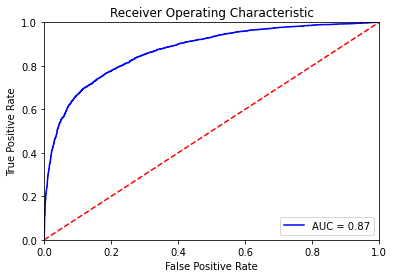

In [10]:
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(t1, s1.view(-1))
roc_auc = metrics.auc(fpr, tpr)
log_dict['fpr'] = fpr
log_dict['tpr'] = tpr
log_dict['threshold'] = threshold


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

tn, fp, fn, tp = conf_mat.ravel()
print(f'sensitivity: {tp/(tp+fn)}')
print(f'specificity: {tn/(tn+fp)}')

In [11]:
print(len(log_dict['fpr']))
rate_idx = 1450
print(log_dict['fpr'][rate_idx])
print(log_dict['tpr'][rate_idx])
print(log_dict['threshold'][rate_idx])

2816
0.20175695461200585
0.7791644058600109
0.2886873


## Analyze Stage Two
Set the desired threshold based on AUC

In [13]:
masks, preds, targets = [], [], []
for fold in range(CFG.nfolds):
    model_fd1 = log_dict[f'stage1_model_{fold}'].to(device=CFG.device, dtype=CFG.dtype)
    model_fd2 = log_dict[f'stage2_model_{fold}'].to(device=CFG.device, dtype=CFG.dtype)
    _, loader_val = data_loader_stage2(fold)
    for inputs, labels in tqdm(loader_val):
        _, C, H, W = inputs[0].shape
        # n_tile[(bs,3,128,128)]-->(bs,n_tile,3,128,128)-->(bs*n_tile,3,128,128)
        inputs = torch.stack(inputs, 1).view(-1,C,H,W).to(device=CFG.device, dtype=CFG.dtype)
                
        # Forward, track history if only in training
        with torch.no_grad():
            probs = model_fd1(inputs).squeeze()
            outputs = model_fd2(inputs)
            # https://github.com/Cysu/open-reid/issues/69
            # torch.cat can't concatenate scalar value. So we use torch.tensor([0]) here
            mask = torch.where(probs<CFG1.threshold,
                               torch.tensor([0]).to(device=CFG.device),
                               torch.tensor([1]).to(device=CFG.device))
            pred = torch.argmax(outputs, 1)
        masks.append(mask)
        targets.append(labels)
        preds.append(pred)

Kappa: 0.2970525226603312


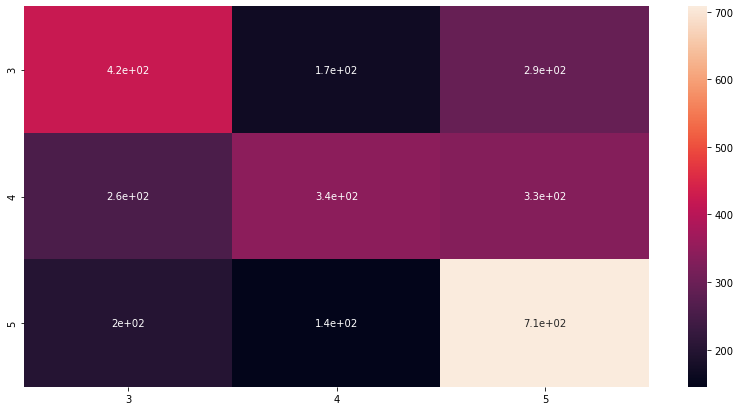

In [14]:
p2 = torch.cat(preds).cpu()
t2 = torch.cat(targets).cpu()
m2 = torch.cat(masks).cpu()

kappa = cohen_kappa_score(t2[m2==1], p2[m2==1], weights='quadratic')
print(f'Kappa: {kappa}')
conf_mat = confusion_matrix(t2[m2==1], p2[m2==1])
#plt.matshow()
plt.figure(figsize=(14,7))
isup_labels = list(range(3,6))
sn.heatmap(conf_mat, annot=True, xticklabels=isup_labels, yticklabels=isup_labels)